In [37]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import DifferentialActionModelPointMass

In [38]:
nx = 4
nu = 2
T = 30
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs0 = Obstacle(10, 8, 2, 1, 'Obs0')
obs1 = Obstacle(3.5, 3.5, 1, 1.5, 'Obs1')
obs2 = Obstacle(6.5, 6.5, 1, 1.5, 'Obs2')
obs3 = Obstacle(6.5, 3.5, 1, 1.5, 'Obs3')
obs_set = [obs1, obs2, obs3]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)

nr = cost_set.nr

In [39]:
# Desired Running and Terminal Model
w_run = np.array([10, 1., 1., 1000, 1000, 1000])
w_term = np.array([2000, 1., 1., 1000, 1000, 1000])
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()
w_run = w_des[:nr]; w_term = w_des[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_opt = mim_solvers.SolverSQP(problem)
sqp_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_opt.with_callbacks=True
sqp_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_opt.solve(xs_init, us_init, 500)
xs_optimal = np.stack(sqp_opt.xs.tolist().copy())
us_optimal = np.stack(sqp_opt.us.tolist().copy())
print(done)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.00750e+02  1.00750e+02  4.77819e+01  1.0000  0.00000e+00  9.94629e+00
   2  1.37160e+00  1.37160e+00  9.41578e+00  1.0000  1.77636e-14  4.26198e-01
   3  1.33424e+00  1.33424e+00  8.00320e+00  1.0000  1.37611e-08  3.40574e-01
   4  1.10799e+00  1.10799e+00  3.97825e+00  1.0000  1.29084e-08  3.40541e-02
   5  1.09119e+00  1.09119e+00  5.24925e-01  1.0000  5.79082e-09  2.57722e-03
   6  1.09111e+00  1.09111e+00  1.48060e-02  1.0000  7.86136e-10  1.41787e-05
 END  1.09111e+00  1.09111e+00  4.91010e-05   ----   2.38718e-11  4.30831e-08
True


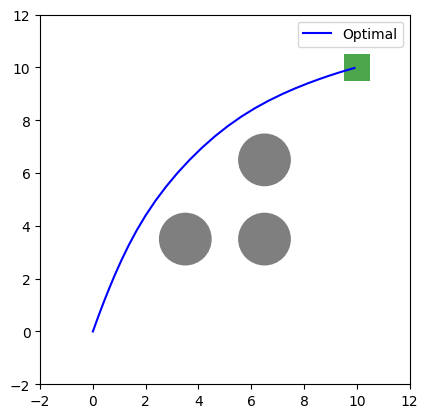

In [40]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_optimal), obs_set, target_high, label='Optimal', linemap = 'b')

In [41]:
# Bad Running and Terminal Model
# w_run = np.array([10, 1., 1., 0., 0., 0.])
# w_term = np.array([1000, 1., 1., 0., 0., 0.])
w_run = np.array([0, 0., 0., 0., 0., 0.])
w_term = np.array([0, 0., 0., 0., 0., 0.])
w_bad = np.hstack([w_run, w_term])
# w_bad = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_bad = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()
w_run = w_bad[:nr]; w_term = w_bad[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_non_opt = mim_solvers.SolverSQP(problem)
sqp_non_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_non_opt.with_callbacks=True
sqp_non_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_non_opt.solve(xs_init, us_init, 500)
xs_non_optimal = np.stack(sqp_non_opt.xs.tolist().copy())
us_non_optimal = np.stack(sqp_non_opt.us.tolist().copy())
print(done)


True
iter     merit         cost         grad      step    ||gaps||        KKT
 END  0.00000e+00  0.00000e+00  0.00000e+00   ----   0.00000e+00  0.00000e+00


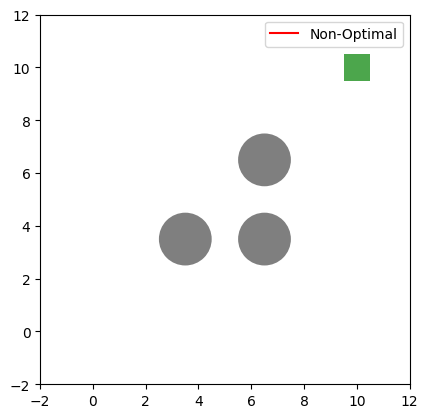

In [42]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_non_optimal), obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [43]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    # x /= np.linalg.norm(x)
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        den += np.exp(-cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_2D(x, cost_set, xs_optimal, us_optimal, xs_non_optimal, us_non_optimal, dt, Lambda = 0.001):
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    den += np.exp(-cost_set.traj_cost(xs_non_optimal, us_non_optimal, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

In [90]:
dt = timeStep
Lambda = 0.0
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 1000, 'iprint': -1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10

e_prev = np.inf
w0 = w_bad
it = 0
it_max = 20
Es = []
xs = []
us = []
ws = []
xs_non_optimal_set = []
us_non_optimal_set = []
xs_non_optimal_set.append(np.vstack(xs_non_optimal).copy())
us_non_optimal_set.append(np.vstack(us_non_optimal).copy())
xs.append(np.vstack(xs_non_optimal).copy())
us.append(np.vstack(us_non_optimal).copy())
ws.append(w_bad)
max_set_size = 10
loop_tol = 0.001
e = 1
while e > loop_tol and it < it_max:
    res = minimize(fcn_w, 
                   w0, 
                   args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda), 
                   bounds=bnds, 
                   method='L-BFGS-B', 
                   tol = tol,
                   options=options)
    w_loop = res.x.copy()
    w_loop /= np.max(w_loop)
    w_run = w_loop[:nr]
    w_term = w_loop[nr:]
    for i in range(T):
        sqp_non_opt.problem.runningModels[i].differential.model.costWeights = w_run
    sqp_non_opt.problem.terminalModel.differential.model.costWeights = w_term
    # done = sqp_non_opt.solve(xs_non_optimal.tolist(), us_non_optimal.tolist(), 100)
    sqp_non_opt.with_callbacks=False
    xs_init = [sqp_non_opt.xs.copy()[i] for i in range(T+1)]
    us_init = [sqp_non_opt.us.copy()[i] for i in range(T)]
    done = sqp_non_opt.solve(xs_init, us_init, 100)
    if it > 0:
        e = np.abs(cost_set.traj_cost(xs_optimal, us_optimal, w_run, w_term, dt)
                   - cost_set.traj_cost(sqp_non_opt.xs.copy(), sqp_non_opt.us.copy(), w_run, w_term, dt))
    # us_non_optimal = sqp_non_opt.us.copy()+np.random.normal(0.0,2.0,np.stack(us_non_optimal.tolist()).shape)
    # xs_non_optimal = np.stack(problem.rollout([us_non_optimal[i] for i in range(T)]))
    xs.append(np.vstack(sqp_non_opt.xs.copy()).copy())
    us.append(np.vstack(sqp_non_opt.us.copy()).copy()+np.random.normal(0.0,5.0,np.stack(us_non_optimal.tolist()).shape))
    ws.append(w_loop.copy())
    Es.append(e)
    if len(xs_non_optimal_set) < max_set_size:
        xs_non_optimal_set = xs
        us_non_optimal_set = us
    else:
        xs_non_optimal_set = xs[-max_set_size:]
        us_non_optimal_set = us[-max_set_size:]
        
    w0 = w_loop.copy()
    print('Error: ', e, 'Traj Cost: ', sqp_non_opt.cost)
    it += 1

print(res)
w_irl = res.x/np.max(res.x)

Error:  1 Traj Cost:  14.581282288122015
Error:  26.08644831462008 Traj Cost:  36.60557532401604
Error:  0.8466298302259796 Traj Cost:  3.168835599572639
Error:  0.07146702380935555 Traj Cost:  3.584064829558e-08
Error:  0.045928778516401425 Traj Cost:  0.5477094989610873
Error:  0.9515872509689522 Traj Cost:  8.078186299925228
Error:  0.3225316841683057 Traj Cost:  3.509507858701986
Error:  0.35768639725214246 Traj Cost:  6.653187423505719
Error:  0.025287271898434716 Traj Cost:  1.6755117242489665
Error:  0.011702790724134493 Traj Cost:  1.11664919846041
Error:  0.0433486946656525 Traj Cost:  3.377657176715468
Error:  0.033170941206015936 Traj Cost:  2.897507116132043
Error:  0.04645809830134284 Traj Cost:  0.8346482786193414
Error:  0.0007401565918219166 Traj Cost:  1.0787592032177127
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 6.211553597883694e-08
        x: [ 2.463e+00  0.000e+00  2.439e-01  2.106e+02  1.993e+02
             

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


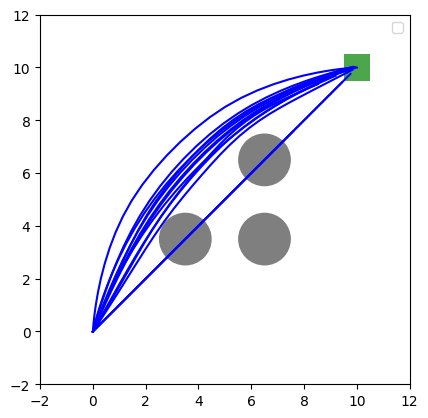

In [91]:
plot_1_set(xs, obs_set, target_high, label='', linemap_traj='b', linemap_set='b')

In [98]:
n = 0
# plot_1_set([xs_optimal, xs[n]], obs_set, target_high, label='', linemap_traj='g:', linemap_set='b')
print(np.abs(cost_set.traj_cost(xs_optimal, us_optimal, ws[n][:nr], ws[n][nr:], dt) -
     cost_set.traj_cost(xs[n], us[n], ws[n][:nr], ws[n][nr:], dt)))

0.0


In [93]:
w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.005 IRL:  0.005610643063796988
Terminal ||  Desired:  1.0 IRL:  1.0

XReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  0.0

UReg :
Running ||  Desired:  0.0005 IRL:  0.0005557185681771209
Terminal ||  Desired:  0.0005 IRL:  0.0

Obs1 :
Running ||  Desired:  0.5 IRL:  0.4796390558510251
Terminal ||  Desired:  0.5 IRL:  0.0

Obs2 :
Running ||  Desired:  0.5 IRL:  0.4539783623911968
Terminal ||  Desired:  0.5 IRL:  1.0622612679821878e-08

Obs3 :
Running ||  Desired:  0.5 IRL:  3.4156917739241464e-05
Terminal ||  Desired:  0.5 IRL:  0.0



In [94]:
print('Desired: ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda)) 
print('IRL:     ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda))

Desired:  2.4009238016951473
IRL:      2.3976183827361117


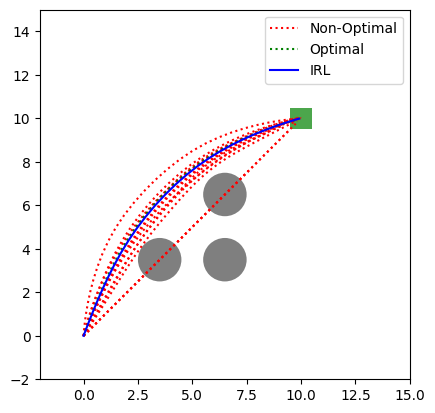

In [95]:
plot_results(xs_optimal, xs[:-1], xs[-1], obs_set, target_high)

In [100]:
# creating sets
all_set_x = []
all_set_u = []
training_set_x = []
training_set_u = []

all_set_x.append(xs[-1]); all_set_x.append(xs_optimal); training_set_x.append(xs_optimal)
all_set_u.append(us[-1]); all_set_u.append(us_optimal); training_set_u.append(us_optimal)

for X, U in zip(xs_non_optimal_set, us_non_optimal_set):
    all_set_x.append(X); training_set_x.append(X)
    all_set_u.append(U); training_set_u.append(U)

In [103]:
P_irl = distributions(cost_set, training_set_x, training_set_u, w_irl[:nr], w_irl[nr:], dt)
P_des = distributions(cost_set, training_set_x, training_set_u, w_des[:nr], w_des[nr:], dt)

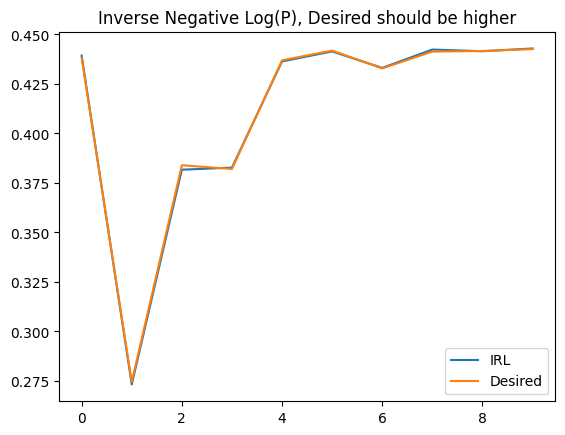

In [105]:
plt.plot(-1/np.log(P_irl[1:]),label='IRL')
plt.plot(-1/np.log(P_des[1:]),label='Desired')
plt.legend()
plt.title('Inverse Negative Log(P), Desired should be higher')
plt.show()